# Project Baseline
Implement a baseline model that reads your data, generates valid outputs, 
and allows its loss/accuracy/performance to be measured. 
A baseline model should be a simple method that gives meaningful results for your task. 
It can be a model that assigns random labels, chooses the most frequent class, or a simpler version of your final model (e.g. a MLP for image classification). Your baseline model should be able to do minibatching and read your train/dev/test data, calculate the average train/dev/test loss and task-specific evaluation metric (e.g. accuracy, f1 score, bleu, iou, etc.) correctly. The aim of this milestone is to setup the code scaffolding for your project and get some initial results without lengthy training. Update your Research Log, Data Sheet and GitHub repo to complete the assignment.


In [1]:
using LightXML
using Images, FileIO
using Knet
using IterTools
using Statistics
using ImageDraw;

PASCAL_classes = Person: person
Animal: bird, cat, cow, dog, horse, sheep
Vehicle: aeroplane, bicycle, boat, bus, car, motorbike, train
Indoor: bottle, chair, dining table, potted plant, sofa, tv/monitor

In [2]:
class_to_index = Dict( (item) => i for (i,item) in enumerate(readlines("classes.txt")) )

Dict{String,Int64} with 20 entries:
  "tvmonitor"   => 20
  "pottedplant" => 18
  "bus"         => 11
  "boat"        => 10
  "train"       => 14
  "sofa"        => 19
  "sheep"       => 7
  "horse"       => 6
  "person"      => 1
  "aeroplane"   => 8
  "diningtable" => 17
  "dog"         => 5
  "chair"       => 16
  "cow"         => 4
  "bottle"      => 15
  "car"         => 12
  "motorbike"   => 13
  "cat"         => 3
  "bicycle"     => 9
  "bird"        => 2

In [3]:
index_to_class = Dict( i => item  for(i,item) in enumerate(readlines("classes.txt")))

Dict{Int64,String} with 20 entries:
  18 => "pottedplant"
  2  => "bird"
  16 => "chair"
  11 => "bus"
  7  => "sheep"
  9  => "bicycle"
  10 => "boat"
  19 => "sofa"
  17 => "diningtable"
  8  => "aeroplane"
  6  => "horse"
  4  => "cow"
  3  => "cat"
  5  => "dog"
  20 => "tvmonitor"
  13 => "motorbike"
  14 => "train"
  15 => "bottle"
  12 => "car"
  1  => "person"

In [4]:
# PATHS
annotation_path = "../VOCdevkit_train2012/VOC2012/Annotations"
images_path = "../VOCdevkit_train2012/VOC2012/JPEGImages"
main_path = "../VOCdevkit_train2012/VOC2012/ImageSets/Main"

train_im_in_path = "$main_path/train.txt"
val_im_in_path = "$main_path/val.txt"


"../VOCdevkit_train2012/VOC2012/ImageSets/Main/val.txt"

In [5]:
struct DataPoint
    image
    bounding_boxes
    DataPoint(image,bounding_boxes) = new(image,bounding_boxes)
end

In [6]:
struct BoundingBox
    class
    xmin
    xmax
    ymin
    ymax
    BoundingBox(class,xmin,xmax,ymin,ymax) = new(class,xmin,xmax,ymin,ymax)
end

In [7]:
# Intersection over union
function IoU( ground_true_bb,predicted_bb)
    
    #predicted_class = predicted_bb[1]
    
    xmin_pred = predicted_bb[1]
    y_min_pred = predicted_bb[2]
    xmax_pred = predicted_bb[3]
    y_max_pred = predicted_bb[4]
    
    #gt_class = ground_true_bb[1]
    
    xmin_gt = ground_true_bb[1]
    y_min_gt = ground_true_bb[2]
    xmax_gt = ground_true_bb[3]
    y_max_gt = ground_true_bb[4]
    
    #  Proposed Intersection
    xmin_intersection = max(xmin_pred,xmin_gt ) # XminOfIntersection
    xmax_intersection = min(xmax_pred,xmax_gt)
    ymax_intersection = min(y_max_pred, y_max_gt )
    ymin_intersection = max(y_min_pred, y_min_gt)
    
    
    # Intersection Area
    interArea = max(0, xmax_intersection - xmin_intersection) * max(0, ymax_intersection - ymin_intersection )
    
    # totalArea =  PredBoxArea + #Grount TruthBox -IntersectionArea
    predBoxArea = abs(xmax_pred - xmin_pred) * abs(y_max_pred - y_min_pred)
    
    gtBoxArea = abs(xmax_gt - xmin_gt) * abs(y_max_gt - y_min_gt)
    
    totalArea =  predBoxArea + gtBoxArea - interArea
    IoU = interArea / (totalArea)
    
    return IoU
    
    
end

IoU (generic function with 1 method)

In [8]:
IoU( [39, 63, 203, 112], [54, 66, 198, 114] )  #(Xmin,ymin,xmax,ymax)

0.7957712638154734

In [9]:
IoU([1,10,30,20,40],[1,12,0,15,20]) # No intersection



0.0

In [10]:
# Takes BoundignBox returns coordinates as Array
function boundingBoxToArray(bb)
    xmin = bb.xmin
    ymin = bb.ymin
    xmax = bb.xmax
    ymax = bb.ymax
    return [xmin,ymin,xmax,ymax]
    
end

boundingBoxToArray (generic function with 1 method)

In [11]:
function imgProcess(img)
    img = imresize(img, (300,300))
    img = img .- mean(img)
    return img
    
end

imgProcess (generic function with 1 method)

In [12]:
function readImage(img_path)
    img = load(img_path)
    
    img = imgProcess(img)
    
    
    img_CHW = channelview(img) # 3*375*500
    
    #reshape
    #img_CHW = img_CHW[:,1:300,1:300]
    
    img_HWC = permutedims(img_CHW, (2, 3, 1))  #375*500*3
    d1 = convert(Array{Float32}, img_HWC)
    return d1
end

readImage (generic function with 1 method)

In [13]:
function creteBBobject(filename)
    xdoc = parse_file(filename)
    xroot = root(xdoc)  # an instance of XMLElement
    
    filename = content(xroot["filename"][1])
    
    bb_array = xroot["object"]
    boxes = []
    for bb in bb_array
        pose = content(find_element(bb, "pose"))
        class = content(find_element(bb, "name"))
        
        xmin = content(find_element(find_element(bb, "bndbox"),"xmin"))
        xmax  = content(find_element(find_element(bb, "bndbox"),"xmax"))
        ymin = content(find_element(find_element(bb, "bndbox"),"ymin"))
        ymax = content(find_element(find_element(bb, "bndbox"),"ymax"))
        
        # String to Integer
        x_min = parse(Int,xmin)
        x_max = parse(Int,xmax)
        y_min = parse(Int,ymin)
        y_max = parse(Int,ymax)
        
        
        # classname --> integer mapping
        class_indx = class_to_index[class]
        
        bbObj = BoundingBox(class_indx,x_min,x_max,y_min,y_max)
        
        
        push!(boxes,bbObj)

    end
    free(xdoc)
    return boxes

end


creteBBobject (generic function with 1 method)

In [14]:
function createPolygons(bbxs)
    polygons = []
    for bb in bbxs
        leftbottom = Point(bb.xmin,bb.ymin)
        rightbottom = Point(bb.xmax,bb.ymin)
        leftTop = Point(bb.xmin,bb.ymax)
        rightTop = Point(bb.xmax, bb.ymax)
        curPoly = Polygon([leftTop,leftbottom,rightbottom,rightTop])
        push!(polygons,curPoly)
    end
    polygons
end

createPolygons (generic function with 1 method)

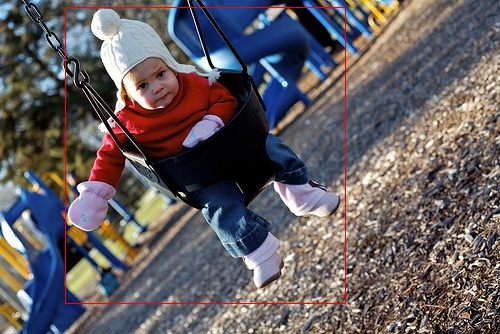

In [15]:
function drawBoundingBoxes(filename)
    annotation_path = "../VOCdevkit_train2012/VOC2012/Annotations"
    images_path = "../VOCdevkit_train2012/VOC2012/JPEGImages"
    
    #readImage
    img_path ="$images_path/$filename.jpg"
    img = load(img_path)
    
    #read BoundingBoxes
    annoth_path = "$annotation_path/$filename.xml"
    bbs = creteBBobject(annoth_path)
    
    #createpolygons
    polygons = createPolygons(bbs)
    
    #draw Bounding Boxes
    for pol in polygons
        draw!(img,pol,RGB{N0f8}(1.0, 0.0, 0.0));
        
    end
    img
    
end
drawBoundingBoxes("2007_005227")

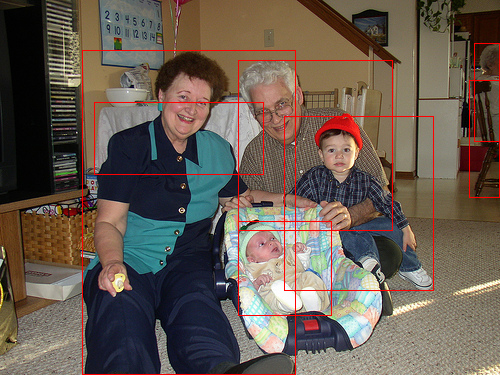

In [16]:
drawBoundingBoxes("2008_001666")

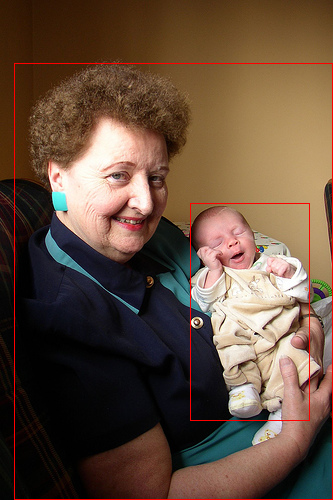

In [17]:
drawBoundingBoxes("2008_001667")

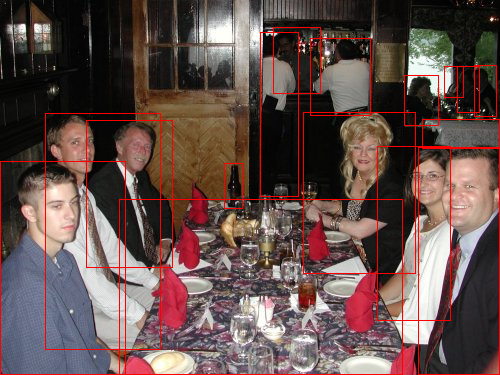

In [18]:
drawBoundingBoxes("2008_002079")

In [19]:
# I need this when I need to read special type of the input.txt file 
function processReadLines(indices)
    cleaned_names = []
    for i in indices
        t  = findfirst(" ",i)
        substr = SubString(i, 1, findfirst(" ",i)[1]-1)
        push!(cleaned_names,substr)
    end
    cleaned_names  
    
end

processReadLines (generic function with 1 method)

In [20]:
function readData(path)
    
    #Training data indexes
    indices = readlines(path)
    
    #indices = processReadLines(indices)
    
    x = []
    y = []
    for idx in indices
        # Read all the bounding boxes in the original dataBounding Box
        bb = creteBBobject("$annotation_path/$idx.xml")
        
        #For baseline first object is targeted to found
        y_fornow = [ bb[1].class,  bb[1].xmin,  bb[1].xmax,  bb[1].ymin,  bb[1].ymax]
       
        # Reads Image
        img = readImage("$images_path/$idx.jpg")
        
        
        #dp = DataPoint(img,bb)
        push!(x,img)
        #Original case
        #push!(y,bb)
        
        # For baseline I am only trying to find one bounding box as a regression problem.
        push!(y,y_fornow)
        
    end
    x = cat(x...,dims=4)
    y = reshape(y, (1,size(y)[1]))
    return (x,y)
    
end


readData (generic function with 1 method)

In [21]:
x_train,y_train = @time readData(train_im_in_path);


183.607073 seconds (30.56 M allocations: 32.006 GiB, 8.17% gc time)


In [22]:
x_val , y_val  = @time readData(val_im_in_path);

205.372640 seconds (27.01 M allocations: 32.384 GiB, 14.92% gc time)


In [23]:
# Minibatches
dtrn = @time minibatch(x_train, y_train, 8; xsize = (300,300,3,:))


  1.585684 seconds (166.32 k allocations: 9.072 MiB)


714-element Knet.Train20.Data{Tuple{Array{Float32,N} where N,Array{Any,N} where N}}

In [24]:
dval = @time  minibatch(x_val, y_val, 8; xsize = (300,300,3,:))

  0.000016 seconds (17 allocations: 656 bytes)


727-element Knet.Train20.Data{Tuple{Array{Float32,N} where N,Array{Any,N} where N}}

In [25]:
#Define a convolutional layer:
struct Conv
    w
    b
    f
    p
end
(c::Conv)(x) = c.f.(pool(conv4(c.w, dropout(x,c.p)) .+ c.b))
Conv(w1::Int,w2::Int,cx::Int,cy::Int,f=relu;pdrop=0) = Conv(param(w1,w2,cx,cy), param0(1,1,cy,1), f, pdrop)

Conv

In [26]:
# Redefine dense layer (See mlp.ipynb):
struct Dense; w; b; f; p; end
(d::Dense)(x) = d.f.(d.w * mat(dropout(x,d.p)) .+ d.b) # mat reshapes 4-D tensor to 2-D matrix so we can use matmul
Dense(i::Int,o::Int,f=relu;pdrop=0.5) = Dense(param(o,i), param0(o), f, pdrop)

Dense

In [27]:
function mean_absolute_error(predictions, targets)
    
    #Predictions -> Bounding Boxes   # Targets -> Ground Truth Bounding Boxes
    # Bounding Box ( xmin, ymin ,xmax,ymax )  
    # (5,10)  number of elements in batch 10
    # 5 -> prediction 1 -> class + 4  bounding boxed
    mbSize = size(targets)[end]
    targets = cat(targets...,dims=2)
    #square(x) = x^2
    batch_loss = sum(abs.(targets.-predictions)) ./ (2*mbSize)
    #println("batch_loss : $batch_loss")
    return batch_loss
end

mean_absolute_error (generic function with 1 method)

In [28]:
# Let's define a chain of layers
struct Chain
    layers
    Chain(layers...) = new(layers)
end

(c::Chain)(x) = (for l in c.layers; x = l(x); end; x)
(c::Chain)(x,y) = mean_absolute_error(c(x),y)



baseline_model =   Chain(Conv(5,5,3,5), 
                Conv(5,5,5,5), 
                Dense(25920,50,pdrop=0.8), 
                Dense(50,5,identity,pdrop=0.8))
                # 5 output for (class,xmin,xmax,ymin,ymax)
summary.(l.w for l in baseline_model.layers)



4-element Array{String,1}:
 "5×5×3×5 Param{Array{Float32,4}}"
 "5×5×5×5 Param{Array{Float32,4}}"
 "50×25920 Param{Array{Float32,2}}"
 "5×50 Param{Array{Float32,2}}"

In [29]:
function (c::Chain)(data::Knet.Train20.Data)
    
    total_loss = 0
    for (x,y) in data
        
        preds = c(x)
        bl = mean_absolute_error(preds,y)
        
        total_loss +=  bl
    end
        
    numberOfbatch = length(data)
    
    avg_b_loss = total_loss/numberOfbatch
    
    println("Total val loss: $total_loss")
    println("Average batch loss: $avg_b_loss")
    return avg_b_loss
end

In [30]:
# Train directly 
#sgd!(baseline_model, dtrn)

In [36]:
# or use Training loop
iteration = 1
val_loss = []
train_loss = []
for (x_b, y_b) in dtrn
    
    # Training cost too much and model is nonsense at this step but if you want to train
    #sgd!(baseline_model,[(x_b,y_b)])
    if iteration % 10 == 0
        valid_loss = baseline_model(dval)
        push!(val_loss,valid_loss)
        println("Val loss : $valid_loss")
        break
    end
    iteration +=1
end

Total val loss: 327051.28
Average batch loss: 449.8642
Val loss : 449.8642


In [32]:
# Validation loss
@time baseline_model(dval)

Total val loss: 327051.28
Average batch loss: 449.8642
 89.630441 seconds (14.16 M allocations: 60.716 GiB, 11.19% gc time)


449.8642f0